In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from mocsy import mocsy

In [9]:
# def mocsy_simp(ii, ij, ji, jj, salinity_ds, temp_ds, TA_ds, DIC_ds):
#     Tinsitu = np.array(gsw.t_from_CT(salinity_ds[ii:ij, ji:jj], temp_ds[ ii:ij, ji:jj], 0))
#     Spsu = 35/35.16504 * np.array(salinity_ds[ ii:ij, ji:jj])
#     TA = np.array(TA_ds[ ii:ij, ji:jj])/1000.
#     DIC = np.array(DIC_ds[ ii:ij, ji:jj])/1000.

#     ones = np.ones_like(Spsu.flatten())

#     response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
#                            dic=DIC.flatten(), 
#                        sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
#                         optcon='mol/m3', optt='Tinsitu', optp='m',
#                         optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
#     pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

#     return pH.reshape([ij-ii, jj-ji]), OmegaA.reshape([ij-ii, jj-ji])

def mocsy_simp(ii, ij, ji, jj, salinity_ds, temp_ds, TA_ds, DIC_ds):
    Tinsitu = np.array(gsw.t_from_CT(salinity_ds, temp_ds, 0))
    Spsu = 35/35.16504 * np.array(salinity_ds)
    TA = np.array(TA_ds)/1000.
    DIC = np.array(DIC_ds)/1000.

    ones = np.ones_like(Spsu.flatten())

    response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pH, OmegaA

In [10]:
year = 2023
chem_day = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_chem_00_05_20230101_20231231.nc').isel(depth=4)
phys_day = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_phys_00_05_20230101_20231231.nc').isel(depth=4)

In [21]:
# chem_year = chem_day.mean(dim='time')
# phys_year = phys_day.mean(dim='time')
phys_test = phys_day.isel(time=0)
phys_test.votemper.shape

(898, 398)

In [12]:
salinity_flat = phys_day.isel(time=0).vosaline.to_numpy().flatten()
temperature_flat = phys_day.isel(time=0).votemper.to_numpy().flatten()
TA_flat = chem_day.isel(time=0).total_alkalinity.to_numpy().flatten()
DIC_flat = chem_day.isel(time=0).dissolved_inorganic_carbon.to_numpy().flatten()

# ii, ij = 0, 898
# ji, jj = 0, 398

# pH_mon = np.zeros(phys_mon['vosaline'].isel(depth=0).shape)
# OmegaA_mon = np.zeros(phys_mon['vosaline'].isel(depth=0).shape)

# for time_idx in np.arange(len(phys_mon['time'])):
#         print(time_idx)
#         pH, OmegaA = mocsy_simp(ii, ij, ji, jj, idepth, phys_mon.isel(time=time_idx), chem_mon.isel(time=time_idx))
#         print(pH.shape)
#         pH_mon[time_idx] = pH
#         OmegaA_mon[time_idx] = OmegaA

In [13]:
ph_flat, omega_flat = mocsy_simp(0, 898, 0, 398, salinity_flat, temperature_flat, TA_flat, DIC_flat)

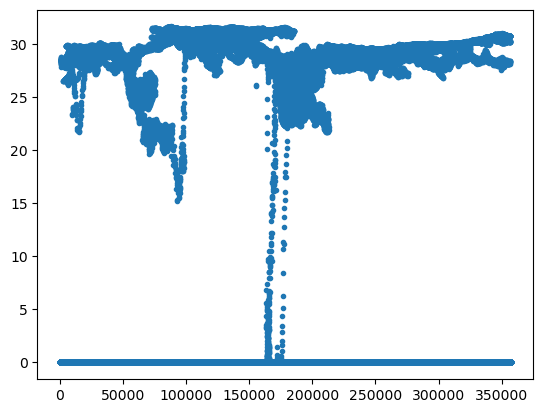

In [16]:
plt.plot(np.arange(len(salinity_flat)), salinity_flat, '.')

In [24]:
salinity_reshape = salinity_flat.reshape([898, 398])
salinity_reshape

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

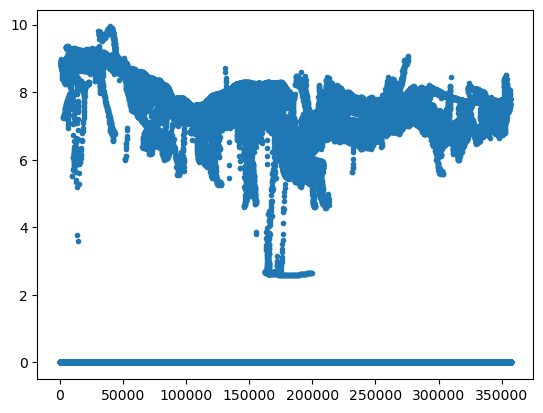

In [17]:
plt.plot(np.arange(len(temperature_flat)), temperature_flat, '.')

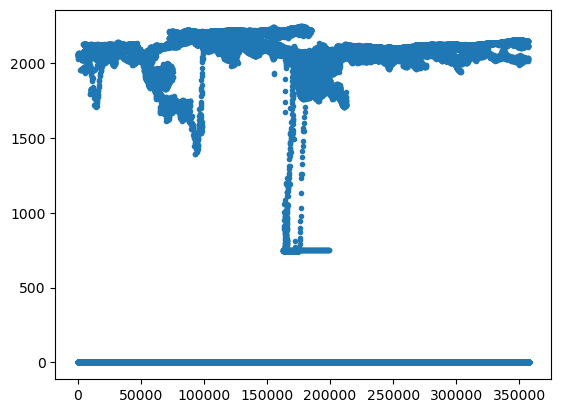

In [18]:
plt.plot(np.arange(len(TA_flat)), TA_flat, '.')

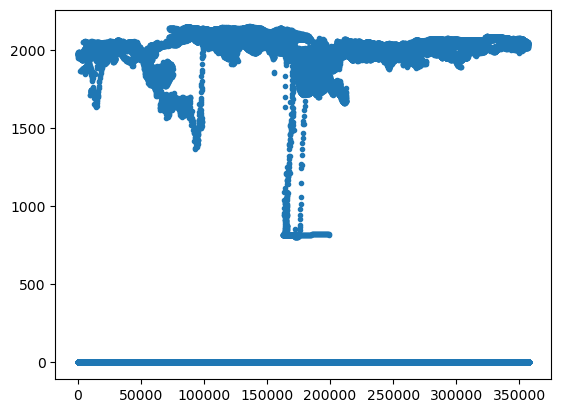

In [19]:
plt.plot(np.arange(len(DIC_flat)), DIC_flat, '.')

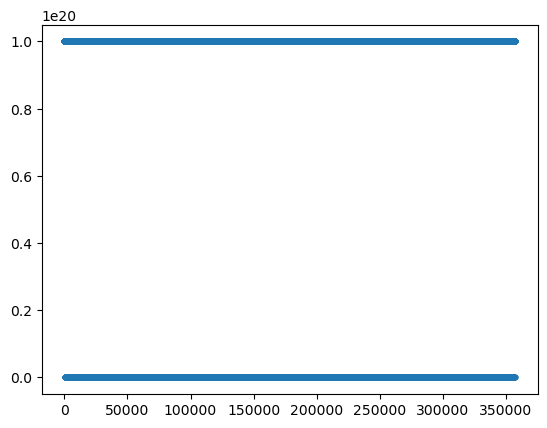

In [15]:
plt.plot(np.arange(len(omega_flat)), omega_flat, '.')

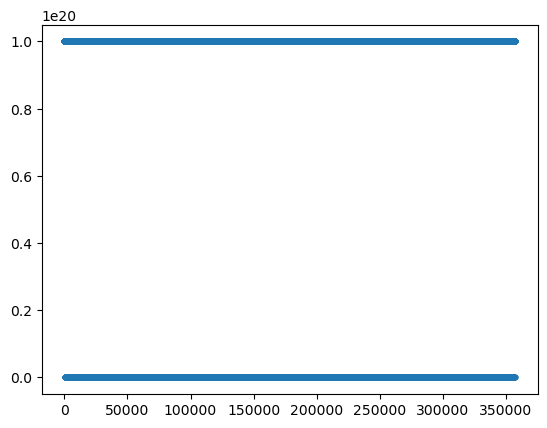

In [14]:
plt.plot(np.arange(len(ph_flat)), ph_flat, '.')